# Tutorial: Calculating Line Ratio Maps

## Introduction
When we have observations of two differnt lines, we commonly are interested to look the peak or the integrated line intensity ratio, which captures changes in the underlying gas physical or chemical conditions.

## Learning Objectives
1. Homogenize radio spectral line data cubes.
2. Calculte the integrated line intensity maps.
3. Calculate the line intensity ratio.

## Pre-requisit Knowlegde:
* What is a convolution? ($\rightarrow$ check out [tutorial 1a](https://github.com/Smithsonian/sma-science-tutorials) **_NOTE:_**  to be updated.)
* How do we determine a mask and what is the moment-0 map? ($\rightarrow$ check out [tutorial 1b](https://github.com/Smithsonian/sma-science-tutorials) **_NOTE:_**  to be updated.)

## Step 1: Import Data Cubes & Homogenize

In [157]:
import radio_beam
from spectral_cube import SpectralCube
from astropy import units as u

import scipy.ndimage as nd
import numpy as np
import matplotlib.pyplot as plt

In [149]:
cube_12co = SpectralCube.read('./data/ngc5194_co21.fits')
cube_13co = SpectralCube.read('./data/ngc5194_13co10.fits')

print('Beam 12CO2-1: %i as'%(cube_12co.beam.major.to(u.arcsec).value))
print('Beam 13CO1-0: %i as'%(cube_13co.beam.major.to(u.arcsec).value))

Beam 12CO2-1: 12 as
Beam 13CO1-0: 26 as


**Convolve to a common beam**

We see that the 13CO is at a coarser resolution, therefore, we need to convolve the 12CO2-1 map.

In [151]:
cube_12co_convolved = cube_12co.convolve_to(cube_13co.beam)

**Reprojection** 

We need to make sure the cubes are on the same coordinate grid. For this purpose, we regrid the 12CO2-1 to the 13CO1-0 grid (a more detailed tutorial can be found [here](https://github.com/radio-astro-tools/tutorials/blob/master/SpectralCubeReprojectExample.ipynb)):

In [153]:
#We have to delete the rest-frame frequency since reprojection is not working properly anymore:
cube_12co_conv_reproj = cube_12co_convolved.reproject(cube_13co.header)


**Caution:** The new astropy reprojection function is very sensitive, if the RESTFRQ key is included in the header. Be sure to remove this as otherwise, the reprojection won't work

## Step 2: Calculate a signal Mask
We have to make sure to integrate over the same signal mask. We use the brighter 12CO(2-1) line to determine the signal mask and then apply it to both line cubes when caclualting the moment-0 maps. We follow here the steps outlined in [tutorial 1b](https://github.com/Smithsonian/sma-science-tutorials):

**Comments on certain aspects of the code**:
* `low_snr_mask`, `high_snr_mask`: You can define different high and low S/N thresholds than the default 6 and 3.
* `low_min_pixels`: Chose here a value corresponding to pixels per beam. If the number of connected pixels is lower, then you know that you are likely only picking up some spurious detection. This number will differ for each observation!

In [7]:
# calculate the rms
mad_std_map = cube_12co_conv_reproj.mad_std(axis=0)
mad_std_map = cube_12co_conv_reproj.with_mask(cube_12co_conv_reproj<3*mad_std_map).mad_std(axis=0)

# Make a low and high mask
low_snr_mask = (cube_12co_conv_reproj > 3 * mad_std_map).include()
high_snr_mask = (cube_12co_conv_reproj > 6 * mad_std_map).include()

#remove spikes along spectral axis
high_snr_mask = high_snr_mask & np.roll(high_snr_mask,1,0)& np.roll(high_snr_mask,-1,0)
low_snr_mask = low_snr_mask & np.roll(low_snr_mask,1,0)& np.roll(low_snr_mask,-1,0)



structure = np.ones((3, 3, 3), dtype=bool)

low_snr_mask_labels, num_labels = nd.label(low_snr_mask,
                                           structure=structure)

num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                     labels=low_snr_mask_labels,
                                     index=range(1, num_labels + 1)) # +1 offset for mask labels

# Repeat for the high signal mask.
num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                    labels=low_snr_mask_labels,
                                    index=range(1, num_labels + 1)) # +1 offset for mask labels

# To preserve the low_snr_mask, we will create a new signal mask where we will remove 
# regions that do not pass the criteria.
signal_mask = low_snr_mask

low_min_pixels = 20
high_min_pixels = 10

for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, num_pixels_in_low_snr_mask)):
    if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
        # This region passes the criteria. Keep it in the mask.
        continue

    # Remove regions that do not pass the criteria.
    # NOTE: enumerate will start with 0, but the mask labels start at 1
    # We apply a +1 offset to `num` to account for this.
    signal_mask[low_snr_mask_labels == num + 1] = False
    
signal_mask_labels, num_labels = nd.label(signal_mask,
                                          structure=structure)

structure = np.ones((3, 3), dtype=bool)

# In the spectral dimension, only expand the original pixel along the spectral dimension.
# The structure looks like:
# [0, 0, 0]
# [0, 1, 0]
# [0, 0, 0]

structure_spec = np.zeros((3, 3), dtype=bool)
structure_spec[1, 1] = True

# Add 1 spectral element on each side of the spatial structure.
# np.dstack stacks the arrays along a new 3rd dimension:
structure = np.swapaxes(np.dstack([structure_spec, structure, structure_spec]), 0, 2)

# With scipy.ndimage:
# import scipy.ndimage as nd

signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)


/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis, overwrite_input=True)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis, overwrite_input=True)


### Step 3: Apply the mask to the cube and calculate the moment maps

After we have calculated the mask based on the highest S/N line available to us, we can apply it to both line cubes.

In [8]:
masked_cube_12co = cube_12co_conv_reproj.with_mask(signal_mask)
masked_cube_13co = cube_13co.with_mask(signal_mask)

In [9]:
masked_moment0_12co = masked_cube_12co.moment0()
masked_moment0_13co = masked_cube_13co.moment0()

Here we plot the ratio as the intensity as $I_{\rm line\,1}/I_{\rm line\,2}$

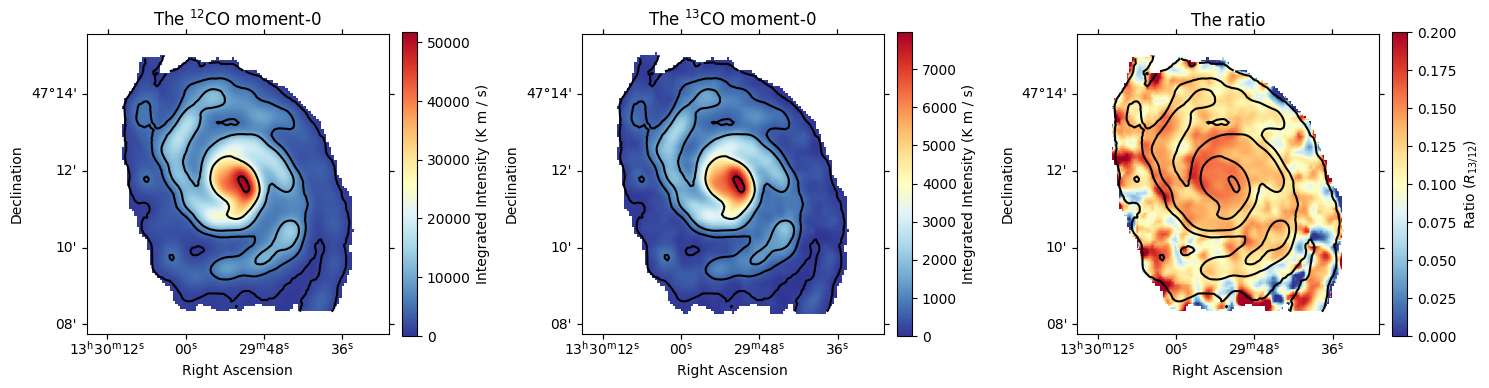

In [172]:
plt.figure(figsize=(15,5))
#-------------------------------------------------------------------------
# Plot the 12CO(2-1) intensity
ax = plt.subplot(1,3,1,projection=masked_moment0_13co.wcs)
im = ax.imshow(masked_moment0_12co.value, origin='lower',  vmin=0,cmap='RdYlBu_r')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(f'Integrated Intensity ({masked_moment0_12co.unit})')
ax.contour(masked_moment0_12co.value/1000, colors='k', levels=[1,5,10,25,50,80])

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')
ax.set_title(r'The $^{12}$CO moment-0')


#-------------------------------------------------------------------------
ax = plt.subplot(1,3,2,projection=masked_moment0_13co.wcs)
im = ax.imshow(masked_moment0_13co.value, origin='lower',vmin=0,cmap='RdYlBu_r')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(f'Integrated Intensity ({masked_moment0_13co.unit})')
ax.contour(masked_moment0_12co.value/1000, colors='k', levels=[1,5,10,25,50,80])

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')
ax.set_title(r'The $^{13}$CO moment-0')

#-------------------------------------------------------------------------

ax = plt.subplot(1,3,3,projection=masked_moment0_13co.wcs)
im = ax.imshow(masked_moment0_13co.value/masked_moment0_12co.value, origin='lower', vmax=.2, vmin=0,cmap='RdYlBu_r')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'Ratio ($R_{13/12}$)')
ax.contour(masked_moment0_12co.value/1000, colors='k', levels=[1,5,10,25,50,80])

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')
ax.set_title('The ratio')

plt.tight_layout()

# Line Ratio Analsyis
A common analysis to perform with the line ratio is:
* Describe line ratio statistics (mean, standard deviation, ...).
* Study trends across the source.

In this tutorial, we will illustrate ways to assess the ratio statistics and in particular look how we can describe radial trends, accounting for the galaxy's inclination and position angle

### i) Uncertainty of the Line Ratio Measurement

To determine the uncertainty in the ratio, $\sigma_{\rm r}$, we can simply propagate the uncertainties of the individual lines, $\sigma_{\rm line\,1}$ and $\sigma_{\rm line\,2}$, as follows:
$$
\sigma_{\rm r} = \frac{I_{\rm line\,1}}{I_{\rm line\,2}}\cdot\sqrt{\left(\frac{\sigma_{\rm line\,1}}{I_{\rm line\,1}}\right)^2+\left(\frac{\sigma_{\rm line\,2}}{I_{\rm line\,2}}\right)^2}
$$

**Determining the integrated line intensity uncertainty:** We have not yet explained, how we determine the uncertainty of the line intensities. As we have the channel rms, we simply find the uncertainty by calculating:
$$
\sigma_{\rm line} = {\rm rms}\cdot\Delta v\cdot\sqrt{n_{\rm chan}}
$$
where $n_{\rm chan}$ indicates the number of channels we integrate over.


In [173]:
#We get the number of channels we integrate over by summing over the mask along the spectral axis
n_chan_cube = np.nansum(signal_mask, axis=0)

#following example above, we compute the channel rms for 12CO and 13CO
mad_std_map_12co = cube_12co_conv_reproj.mad_std(axis=0)
mad_std_map_12co = cube_12co_conv_reproj.with_mask(cube_12co_conv_reproj<3*mad_std_map_12co).mad_std(axis=0)

mad_std_map_13co = cube_13co.mad_std(axis=0)
mad_std_map_13co = cube_13co.with_mask(cube_13co<3*mad_std_map).mad_std(axis=0)

#compute the uncertaitny of the intensity
delta_v = cube_12co_conv_reproj.header['CDELT3']
unc_ii_12co = mad_std_map_12co.value*delta_v*np.sqrt(n_chan_cube)
unc_ii_13co = mad_std_map_13co.value*delta_v*np.sqrt(n_chan_cube)

/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis, overwrite_input=True)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis, overwrite_input=True)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:816: RuntimeWarning: All-NaN slice encountered
  data_median = func(data, axis=axis)
/opt/homebrew/lib/python3.11/site-packages/astropy/stats/funcs.py:822: RuntimeWarning: All-NaN slice encountered
  result = func(np.abs(data - data_median), axis=axis,

**Propagate the Uncertainty to determine the error in line ratio**

In [142]:
#compute first the term in the square-root
term1=unc_ii_13co/masked_moment0_13co.value
term2=unc_ii_12co/masked_moment0_12co.value

sqrt_term = np.sqrt((term1)**2+(term2)**2)

#resulting uncertainty
unc_ratio = masked_moment0_13co.value/masked_moment0_12co.value*sqrt_term

### ii) Sample-wide Ratio Distribution
Here we present the simplest analysis, which consists of illustrating the distribution of ratio values using a histogram

We want to make sure we only include pixels with significantly detected emission in both ratios

In [174]:
#we flatten the ratio, since we are only interested in the 1D distribution

#calculate the signal-to-noise ratios
snr_12co = masked_moment0_12co.value.flatten()/unc_ii_12co.flatten()
snr_13co = masked_moment0_13co.value.flatten()/unc_ii_13co.flatten()

#determine pixels that are significant (S/N>3)
id_sig = np.where((snr_12co>3) & (snr_13co>3))

In [175]:
ratio_all = masked_moment0_13co.value.flatten()/masked_moment0_12co.value.flatten()

Average Ratio: 0.12+0.03-0.03


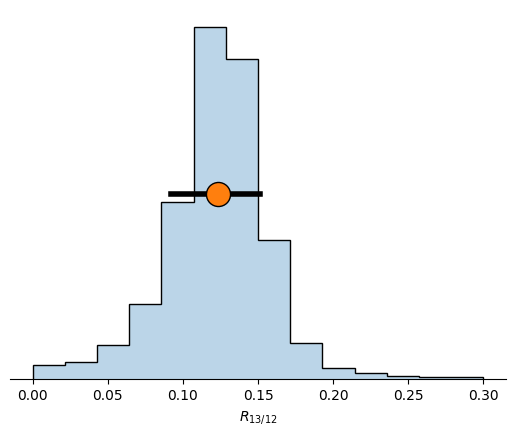

In [194]:
ax = plt.subplot(1,1,1)

#make a pretty histogram layout
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.set_yticks([])
plt.xlabel(r"$R_{13/12}$")

#define a range of bins
xx = np.linspace(0,.3, 15)

#plot the histogram
plt.hist(ratio_all, bins=xx, density=True, histtype='step', fill=False, color='k')
plt.hist(ratio_all, bins=xx, density=True, alpha=.3)

#calculate median and 16th to 84th percentile
median = np.nanmedian(ratio_all)
up_84th = np.nanpercentile(ratio_all,84)
low_16th = np.nanpercentile(ratio_all,16)

#show median and percentile range
plt.plot([low_16th,up_84th],2*[0.5*ax.get_ylim()[-1]], lw=4, color='k')
plt.scatter([median],[0.5*ax.get_ylim()[-1]], edgecolor='k',s=300,zorder=10)

print("Average Ratio: %.2f+%.2f-%.2f"%(median,up_84th-median,median-low_16th))

### iii) Radial Trends in the Line Ratio

**Specify the galaxy parameters**

(Note that this will be very similar for a disk instead of a galaxy)

In [118]:
#Specify 
central_coordinates = "13:29:52.7 47:11:43" #The coordinates in Ra and Dec
inclination = 20                            #in degrees
position_angle = 178                        #in degrees
distance_mpc = 8.5                          #in Megaparsec

In [119]:
from astropy.coordinates import SkyCoord, FK5
import astropy.units as au

# Define the reference coordinate (RA, Dec)
ref_coord =SkyCoord(central_coordinates, frame=FK5, unit=(au.hourangle, au.deg))
        
# Get the shape of the image
ny, nx = masked_moment0_12co.shape

In [ ]:
# Step 1: Create a grid of pixel coordinates
y, x = np.mgrid[0:ny, 0:nx]
coords = np.column_stack((x.ravel(), y.ravel()))

In [ ]:
# Step 2:Convert pixel coordinates to sky coordinates
sky_coords = masked_moment0_12co.wcs.pixel_to_world(coords[:, 0], coords[:, 1])

sep = sky_coords.separation(ref_coord).deg
pa = sky_coords.position_angle(ref_coord).deg

In [ ]:
# Step 3: Deproject the distances
pa_rad = np.deg2rad(pa)
inc_rad = np.deg2rad(inclination)

x_proj = sep * np.cos(pa_rad - np.deg2rad(position_angle))
y_proj = sep * np.sin(pa_rad - np.deg2rad(position_angle)) / np.cos(inc_rad)

deprojected_distances = np.sqrt(x_proj**2 + y_proj**2)
deprojected_pa = np.arctan2(y_proj, x_proj)

In [ ]:
# Step 4: Reshape to the original image shape
deprojected_distances_map = deprojected_distances.reshape((ny, nx))
deprojected_pa_map = np.rad2deg(deprojected_pa).reshape((ny, nx))

In [126]:
# Step 5: Convert the deprojected_distances_map to galactocentric radius in kpc
deprojected_distances_kpc = np.deg2rad(deprojected_distances_map)*distance_mpc*1e3

**Make a radial scatter plot as function of galactocentric radius**

(0.0, 0.4)

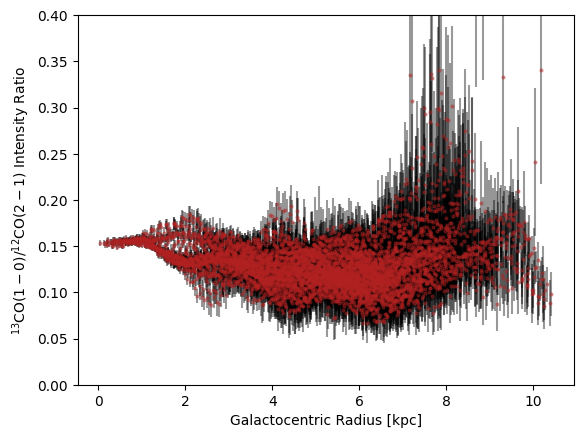

In [141]:
plt.figure()
ax=plt.subplot(1,1,1)
ax.errorbar(deprojected_distances_kpc.flatten()[id_sig],ratio_all[id_sig], fmt='.', color='firebrick',yerr = unc_ratio.flatten()[id_sig], ecolor='k', ms=4, alpha=.4)

ax.set_ylabel(r'$^{13}\rm CO(1-0)/^{12}CO(2-1)$ Intensity Ratio')
ax.set_xlabel('Galactocentric Radius [kpc]')

ax.set_ylim(0,0.4)

**Note on the result:**

We can compare our result here to those in recent literature. For instance, the resolved ratio is presented and stuied across M51 in [den Brok+(2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...662A..89D/abstract). We find the same ratio ($\langle R_{13/12}\rangle=0.12$) as reported in their table 6.

# Remaining challenge:

A thing to note is that we are here dealing with a significant oversampling, leading to correlated scatter points. Ideally, we would first resample the data cubes to a coarser grid to minimize the oversampling. 

An example pipeline that can handle resampling of radio-astronomic data cubes is the [PyStructure code](https://github.com/jdenbrok/PyStructure/tree/main). This code will convolve and regrid input data to a common grid, ensuring minimal oversampling to still ensure Nyquist sampling. 